In [2]:
from configparser import ConfigParser
import psycopg2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def config(filename='./database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
  
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
  
    return db

def connect_and_execute(raw_sql_query):
    """ Connect to the PostgreSQL database server """
    conn = None
    sql_result = None
    try:
        # read connection parameters
        params = config()
  
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
          
        # create a cursor
        cur = conn.cursor()

        cur.execute(raw_sql_query)        
        sql_result = cur.fetchall()
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return sql_result

In [4]:
print(connect_and_execute('SELECT version()'))

Connecting to the PostgreSQL database...
Database connection closed.
[('PostgreSQL 15.2 on aarch64-unknown-linux-musl, compiled by gcc (Alpine 12.2.1_git20220924-r4) 12.2.1 20220924, 64-bit',)]


In [5]:
print("Najwcześniejszy pomiar: ", connect_and_execute('SELECT min("Date") FROM public."SheetEntities"'))


Connecting to the PostgreSQL database...
Database connection closed.
Najwcześniejszy pomiar:  [(datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),)]


In [6]:
time_range_per_station = connect_and_execute("""                                             
SELECT "TimeRange", count("TimeRange"), "StationName", count("StationName") FROM public."SheetEntities"
Group by "TimeRange", "StationName";
                                             
                                             """)

df_ik = pd.DataFrame(time_range_per_station, columns=["TimeRange", "CountTimeRange", "StationName", "MeasurementsInRow"])
print(df_ik)

df_1h = df_ik.loc[df_ik['TimeRange'] == 1]
df_24h = df_ik.loc[df_ik['TimeRange'] == 24]



Connecting to the PostgreSQL database...
Database connection closed.
    TimeRange  CountTimeRange           StationName  MeasurementsInRow
0           1          271704  LdPiotrkWIOSAKrakPrz             271704
1           1          184128          MpKaszowLisz             184128
2           1          385752          MpKrakAlKras             385752
3           1          420792          MpKrakBujaka             420792
4           1          455880          MpKrakBulwar             455880
5           1          175344          MpKrakDietla             175344
6           1           52608          MpKrakOsPias              52608
7           1           26304          MpKrakSwoszo              26304
8           1           17520          MpKrakTelime              17520
9           1           43824           MpKrakWadow              43824
10          1           52608          MpKrakZloRog              52608
11          1          622368  MpKrakowWIOSAKra6117             622368
12      

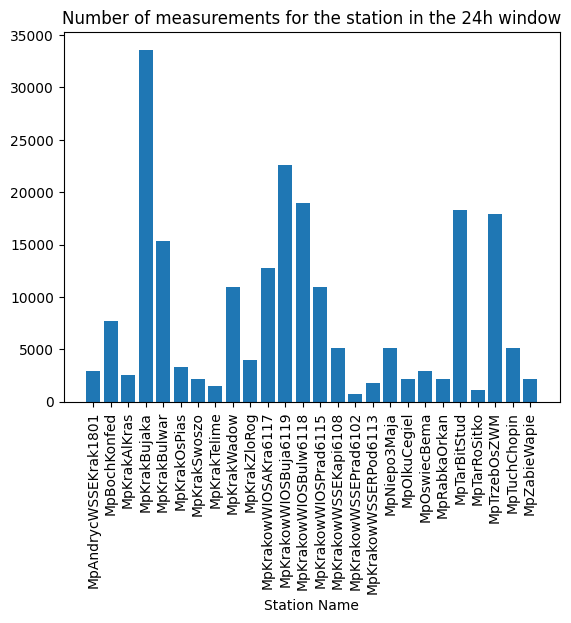

In [7]:

# Tworzenie histogramu
plt.bar(df_24h["StationName"], df_24h["CountTimeRange"])

# Tytuł i etykiety osi
plt.title("Number of measurements for the station in the 24h window")
plt.xlabel("Station Name")

# Obrót etykiet na osi X, aby były czytelne
plt.xticks(rotation=90)

plt.show()

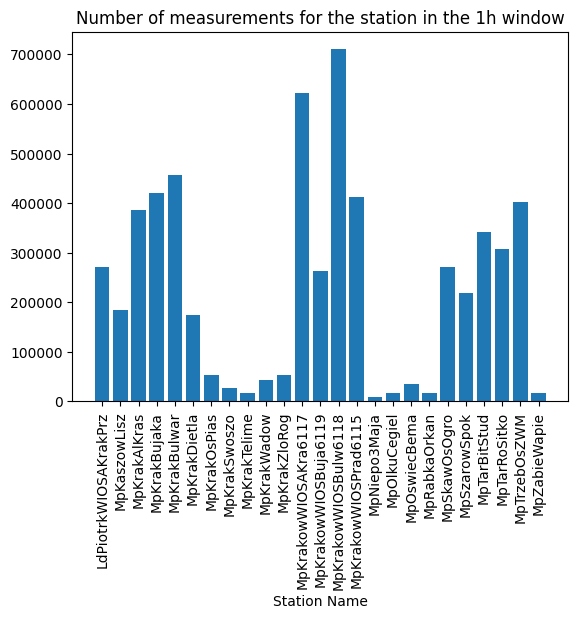

In [8]:

# Tworzenie histogramu
plt.bar(df_1h["StationName"], df_1h["CountTimeRange"])

# Tytuł i etykiety osi
plt.title("Number of measurements for the station in the 1h window")
plt.xlabel("Station Name")

# Obrót etykiet na osi X, aby były czytelne
plt.xticks(rotation=90)

plt.show()

In [9]:

min_max_range_per_station = connect_and_execute("""                                             
SELECT min("Date") as "min", max("Date") as "max", "StationName", count("StationName") as "l_pomiarow" FROM public."SheetEntities"
Group by"StationName";                                             
                                             """)


print(min_max_range_per_station)

df = pd.DataFrame(min_max_range_per_station, columns=["min", "max", "StationName", "l_pomiarow"])
df.head(20)


Connecting to the PostgreSQL database...
Database connection closed.
[(datetime.datetime(2009, 1, 1, 1, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), 'LdPiotrkWIOSAKrakPrz', 271704), (datetime.datetime(2003, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2009, 12, 31, 0, 0, tzinfo=datetime.timezone.utc), 'MpAndrycWSSEKrak1801', 2922), (datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc), 'MpBochKonfed', 7671), (datetime.datetime(2016, 1, 1, 1, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), 'MpKaszowLisz', 184128), (datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), 'MpKrakAlKras', 388309), (datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2022, 1, 1, 0, 0, tzinfo=dat

,min,max,StationName,l_pomiarow
0,2009-01-01 01:00:00+00:00,2015-01-01 00:00:00+00:00,LdPiotrkWIOSAKrakPrz,271704
1,2003-01-01 00:00:00+00:00,2009-12-31 00:00:00+00:00,MpAndrycWSSEKrak1801,2922
2,2015-01-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,MpBochKonfed,7671
3,2016-01-01 01:00:00+00:00,2022-01-01 00:00:00+00:00,MpKaszowLisz,184128
4,2015-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,MpKrakAlKras,388309
5,2015-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,MpKrakBujaka,454398
6,2015-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,MpKrakBulwar,471222
7,2016-01-01 01:00:00+00:00,2022-01-01 00:00:00+00:00,MpKrakDietla,175344
8,2016-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,MpKrakOsPias,55895
9,2019-01-01 00:00:00+00:00,2022-01-01 00:00:00+00:00,MpKrakSwoszo,28496


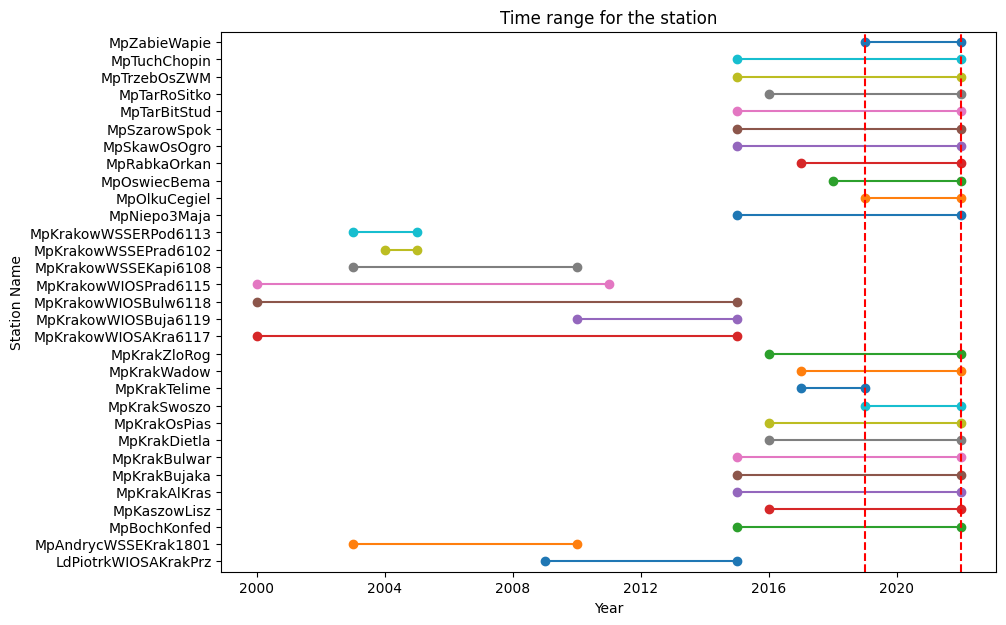

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), gridspec_kw={'top': 0.95, 'bottom': 0.05})


# # Konwersja wartości min i max na obiekty daty
# df["min"] = pd.to_datetime(df["min"])
# df["max"] = pd.to_datetime(df["max"])

# Tworzenie wykresu liniowego
for i, row in df.iterrows():
    ax.plot([row["min"], row["max"]], [row["StationName"], row["StationName"]], marker='o')

# Tytuł i etykiety osi
ax.set_title("Time range for the station")
ax.set_xlabel("Year")
ax.set_ylabel("Station Name")

# Dodawanie pionowej kreski dla roku 2019
ax.axvline(x=pd.to_datetime("2019-01-01"), color='red', linestyle='--')
ax.axvline(x=df["max"].max(), color='red', linestyle='--')

# Ustawienie paddingu dla pierwszego i ostatniego elementu
ax.margins(y=0.02)

plt.show()

Connecting to the PostgreSQL database...
Database connection closed.


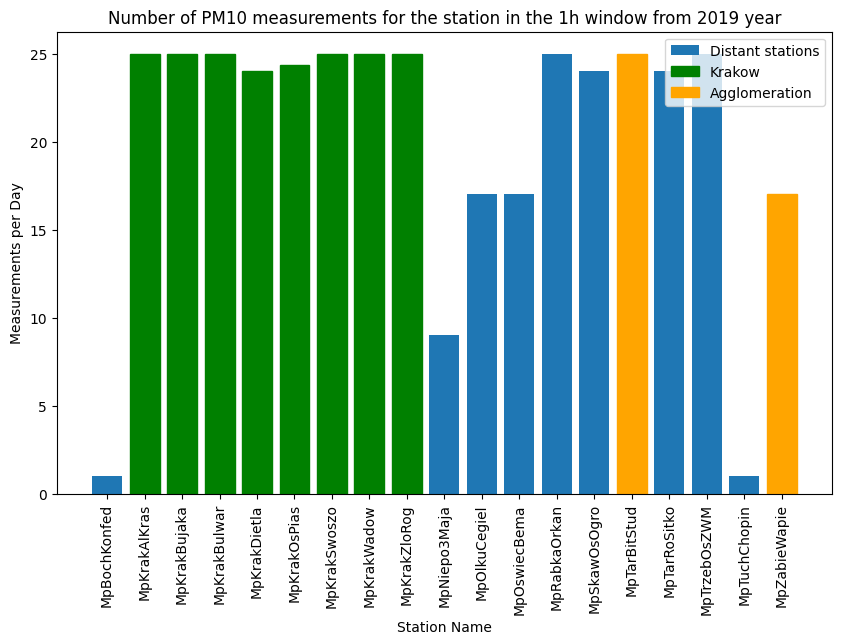

In [38]:
partial_time_range_per_station = connect_and_execute("""                                             
SELECT
min("Date") as "min",
max("Date") as "max", max("Date") - min("Date") as "diff",
"StationName",
count("StationName") as "l_pomiarow"
FROM public."SheetEntities"
Where "Date" >'2019-01-01' AND
"PollutantName" = 'PM10'
Group by "StationName"
Order by "StationName"
                                             
                                             """)

df_ik2 = pd.DataFrame(partial_time_range_per_station, columns=["Min", "Max", "Diff", "StationName", "MeasurementsInRow"])

df_ik2['Diff_h'] = df_ik2['Diff'].apply(lambda x: x.days)
df_ik2['Measurements_per_day'] = df_ik2['MeasurementsInRow'] / df_ik2['Diff_h'] 


# print(df_ik2.dtypes)
# print(df_ik2)


# Tworzenie histogramu
fig, ax = plt.subplots(figsize=(10, 6))

# Rysowanie słupków histogramu
bars = ax.bar(df_ik2["StationName"], df_ik2["Measurements_per_day"])

for i, index in enumerate(range(1, 9)):
    bars[index].set_color('green')

obwarzan_ind = [14, 18]
for i, index in enumerate(obwarzan_ind):
    bars[index].set_color('orange')

# Tytuł i etykiety osi
ax.set_title("Number of PM10 measurements for the station in the 1h window from 2019 year")
ax.set_xlabel("Station Name")
ax.set_ylabel("Measurements per Day")


bars[1].set_label('Krakow')
bars[14].set_label('Agglomeration')
bars[0].set_label('Distant stations')

# Dodanie legendy
plt.legend()

# Obrót etykiet na osi X, aby były czytelne
plt.xticks(rotation=90)

# Ustawienie paddingu tylko dla pierwszego i ostatniego słupka

plt.show()